In [3]:
from pysheds.grid import Grid

In [4]:
#grid = Grid.from_raster('ondemand/SWOT_discharge/data/outputs/ohio_dem.tif')
#dem = grid.read_raster('ondemand/SWOT_discharge/data/outputs/ohio_dem.tif')

grid = Grid.from_raster('/home/rajani/Downloads/ohio_dem.tiff')
dem = grid.read_raster('/home/rajani/Downloads/ohio_dem.tiff')

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import geopandas as gpd

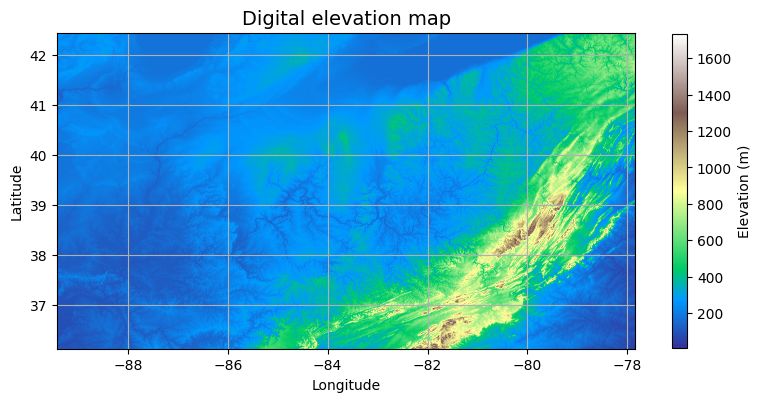

In [6]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(dem, extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)', shrink=0.55)
plt.grid(zorder=0)
plt.title('Digital elevation map', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

In [7]:
print(dem.min(), dem.max())

12.4831085 1732.1719


In [8]:
# Condition DEM
# ----------------------
# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)
print(pit_filled_dem.min(), pit_filled_dem.max())

13.28230094909668 1732.171875


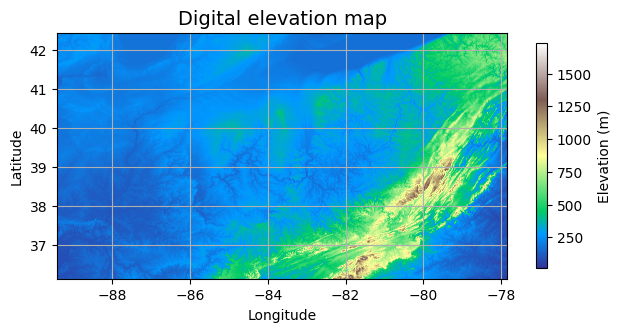

In [9]:
plt.imshow(pit_filled_dem, extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)', shrink=0.5)
plt.grid(zorder=0)
plt.title('Digital elevation map', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

In [10]:
# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)

In [11]:
print(flooded_dem.min(), flooded_dem.max())

35.552650451660156 1732.171875


In [12]:
# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)
print(inflated_dem.min(), inflated_dem.max())

35.552670451660155 1732.171875


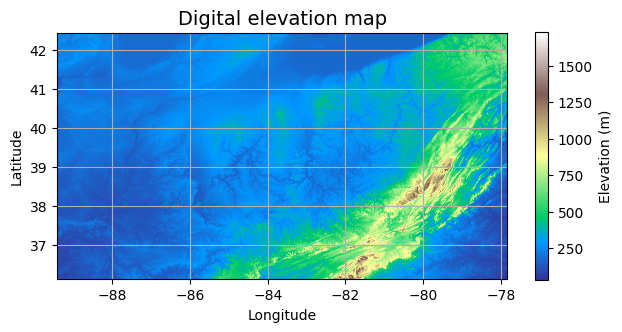

In [13]:
plt.imshow(inflated_dem, extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)', shrink=0.55)
plt.grid(zorder=0)
plt.title('Digital elevation map', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

In [14]:
# Determine D8 flow directions from DEM
# ----------------------
# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
    
# Compute flow directions
# -------------------------------------
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

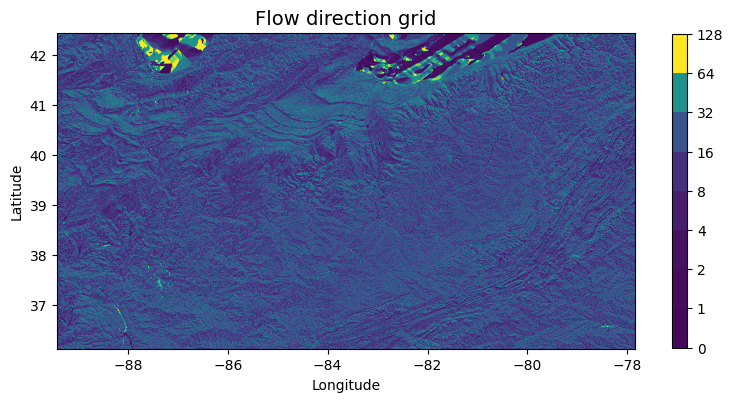

In [15]:
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap), shrink=0.55)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid', size=14)
plt.grid(zorder=-1)
plt.tight_layout()

In [16]:
# Calculate flow accumulation
# --------------------------
acc = grid.accumulation(fdir, dirmap=dirmap)


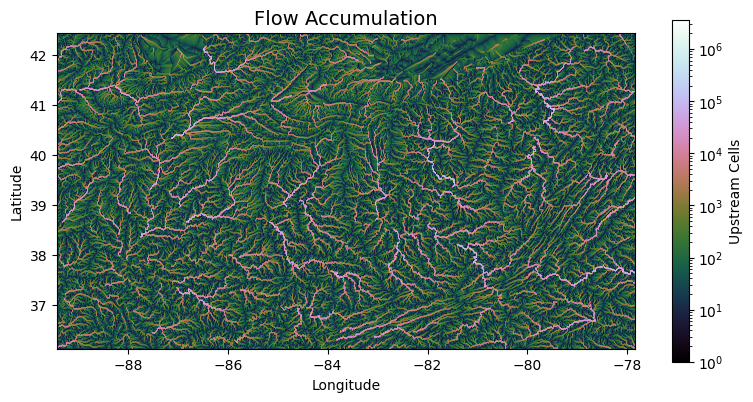

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells', shrink=0.60)
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

In [18]:
# Extract river network
# ---------------------
branches = grid.extract_river_network(fdir, acc > 100000)
branches_50k = grid.extract_river_network(fdir, acc > 50000)

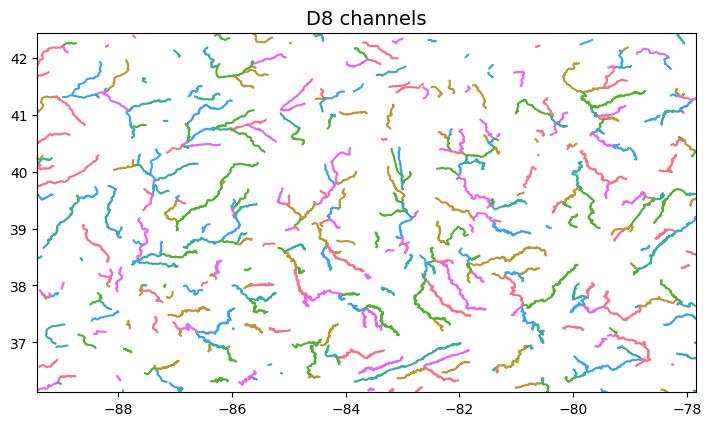

In [26]:
sns.set_palette('husl')
fig, ax = plt.subplots(figsize=(8.5,6.5))

plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect('equal')

for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])
    
_ = plt.title('D8 channels', size=14)

In [27]:
# Convert FeatureCollection to GeoDataFrame
geometries = [feature['geometry'] for feature in branches['features']]
properties = [feature['properties'] for feature in branches['features']]
gdf_branches = gpd.GeoDataFrame(properties, geometry=geometries)

geometries = [feature['geometry'] for feature in branches_50k['features']]
properties = [feature['properties'] for feature in branches_50k['features']]
gdf_branches_50k = gpd.GeoDataFrame(properties, geometry=geometries)

In [23]:
# Load the shapefile using GeoPandas
shapefile_path = '/mnt/sda/projects/SWOT_discharge/data/na_sword_reaches_hb74_v15.shp'  
shapefile = gpd.read_file(shapefile_path) 

(36.122083333, 42.4487499996667)

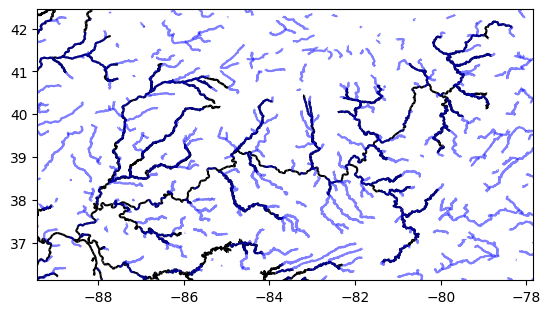

In [24]:
fig, ax = plt.subplots(1)
shapefile.plot(ax = ax, edgecolor='black', figsize=(10, 8))
#gdf_branches.plot(ax = ax)
gdf_branches.plot(ax=ax, color='blue', alpha=0.5)
# Set limits for the plot based on your grid
plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])


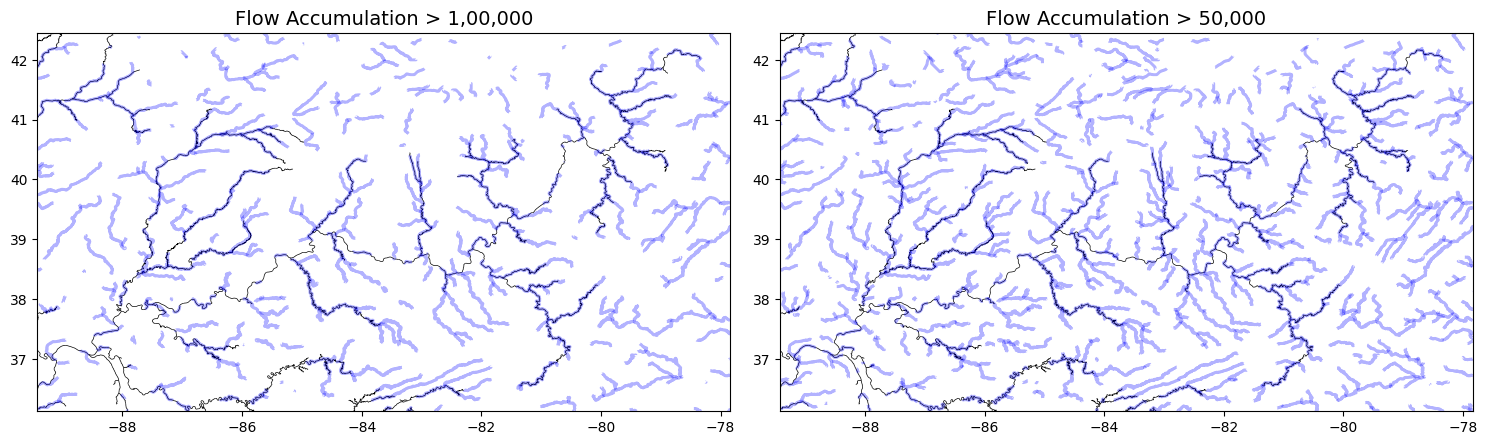

In [28]:
# Create a figure with 1 row and 2 columns of subplots (side by side)
fig, ax = plt.subplots(1, 2, figsize=(15, 10))  # 1 row, 2 columns

# Plot the first figure (Flow Accumulation > 1,00,000) on the first subplot
shapefile.plot(ax=ax[0], edgecolor='black', alpha=1, linewidth=0.5)
gdf_branches.plot(ax=ax[0], color='blue', alpha=0.3, linewidth=2.1)
ax[0].set_xlim(grid.bbox[0], grid.bbox[2])
ax[0].set_ylim(grid.bbox[1], grid.bbox[3])
ax[0].set_title('Flow Accumulation > 1,00,000', size=14)

# Plot the second figure (Flow Accumulation > 50,000) on the second subplot
shapefile.plot(ax=ax[1], edgecolor='black', alpha=1, linewidth=0.5)
gdf_branches_50k.plot(ax=ax[1], color='blue', alpha=0.3, linewidth=2.1)
ax[1].set_xlim(grid.bbox[0], grid.bbox[2])
ax[1].set_ylim(grid.bbox[1], grid.bbox[3])
ax[1].set_title('Flow Accumulation > 50,000', size=14)

# Display the figure with both plots side by side
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()